# Optimal Position Generator

Generates optimal positions for use in mahine learning

## Imports

In [32]:
%matplotlib inline
import kydb
from datetime import date, datetime
from ml.optimal_position import OptimalPositionGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import bz2
import s3fs
import os

## Setup

Start and End Date

In [ ]:
start_date = date(2017, 6, 1)
end_date = date(2020, 6, 1)

Get the TSDB 

In [19]:
db = kydb.connect('dynamodb://epython/timeseries')
ts = db['symbols/bitflyer/minutely/FX_BTC_JPY']

## Create the optimal positions for training

In [28]:
opg = OptimalPositionGenerator(ts, start_date, end_date)
optimal = opg.generate()
optimal = optimal.sort_index()

## Visualise the result

Pick some random 3 days window and see the optimal trading.

Green to buy and red to sell.

In [53]:
def get_trades(df):
    df = df.join(df[['position']].shift(), rsuffix='_prev').fillna(0.)
    return df[df.position != df.position_prev]

trades_df = get_trades(optimal)

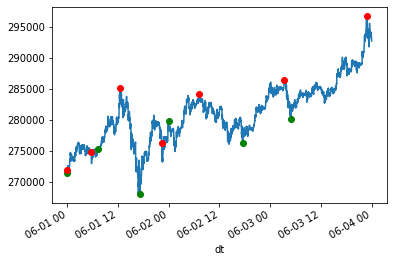

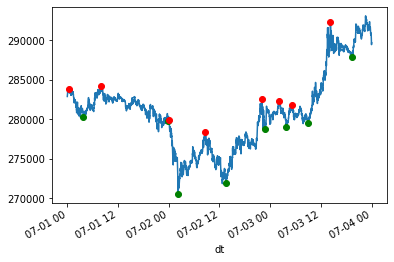

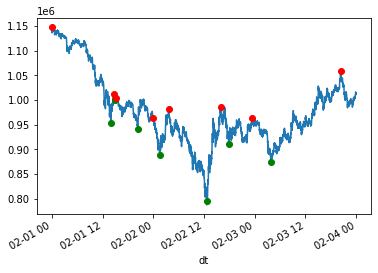

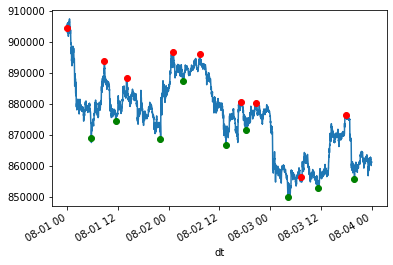

In [63]:

def plot_trades(start_dt, end_dt):
    optimal[start_dt:end_dt].mid.plot()
    trades = trades_df[start_dt:end_dt]
    trades[trades.position > 0.].mid.plot(style='go')
    trades[trades.position < 0.].mid.plot(style='ro')
    
plot_trades('2017-06-01', '2017-06-03')
plt.show()
plot_trades('2017-07-01', '2017-07-03')
plt.show()
plot_trades('2018-02-01', '2018-02-03')
plt.show()
plot_trades('2018-08-01', '2018-08-03')
plt.show()

## Persist Result

In [82]:
local_filename = '/tmp/OptimalPosition.csv.bz2'
optimal.to_csv(local_filename)

In [83]:
PATH = 's3://epython-marketdata/ml/training_data/symbol=FX_BTC_JPY/OptimalPosition.csv.bz2'
s3 = s3fs.S3FileSystem()

with open(local_filename, 'rb') as f:
    data = f.read()

with s3.open(PATH, 'wb') as f:
    f.write(data)

In [85]:
os.remove(local_filename)

## Create TimeSeries

In [103]:
sql_template_path = '/templates/training_data_fxbtcjpy.sql'

db[sql_template_path] = '''
WITH t AS
    (SELECT date_parse(dt,
        '%Y-%m-%d %H:%i:%S') AS dt,
        bid, ask, mid, position
    FROM training_data
    WHERE symbol = '{pair}')
SELECT *
FROM t
WHERE dt
    BETWEEN timestamp '{start_dt:%Y-%m-%d %H:%M:%S}'
        AND timestamp '{end_dt:%Y-%m-%d %H:%M:%S}'
'''

In [104]:
ts = db.new('AthenaTimeSeries', '/symbols/ml/training_data/FX_BTC_JPY',
    database='epython-marketdata',
    res_s3_path = 's3://epython-athena/result-cache/',
    sql_template_path=sql_template_path,
    sql_kwargs={'pair': 'FX_BTC_JPY'})
ts.write()

Test the TimeSeries

In [106]:
print(ts.sql(datetime(2018, 6, 5, 9, 0), datetime(2018, 6, 5, 9, 10)))


WITH t AS
    (SELECT date_parse(dt,
        '%Y-%m-%d %H:%i:%S') AS dt,
        bid, ask, mid, position
    FROM training_data
    WHERE symbol = 'FX_BTC_JPY')
SELECT *
FROM t
WHERE dt
    BETWEEN timestamp '2018-06-05 00:00:00'
        AND timestamp '2018-06-05 00:00:00'



In [110]:
ts.curve(date(2018, 6, 5), date(2018, 6, 6))

,bid,ask,mid,position
dt,,,,
2018-06-05 00:00:01,853528.0,853599.0,853563.5,-1.0
2018-06-05 00:01:01,854146.0,854191.0,854168.5,-1.0
2018-06-05 00:02:00,854266.0,854378.0,854322.0,-1.0
2018-06-05 00:03:01,854442.0,854500.0,854471.0,-1.0
2018-06-05 00:04:01,854430.0,854469.0,854449.5,-1.0
...,...,...,...,...
2018-06-05 23:56:01,869442.0,869460.0,869451.0,-1.0
2018-06-05 23:57:01,869303.0,869309.0,869306.0,-1.0
2018-06-05 23:58:01,869694.0,869698.0,869696.0,-1.0
